## Notebook para Treinamento e Avaliação de Modelos Shallow

Baseado no artigo: Neural Networks Forecast Models Comparison for the Solar Energy Generation in Amazon Basin

>Replicação Otimizada

### 1. Importação das Bibliotecas

In [155]:
!pip install matplotlib pandas numpy scikit-learn statsmodels xgboost scipy

In [156]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from scipy.stats import uniform as sp_uniform, randint as sp_randint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

### 2. Configuração Inicial e Parâmetros

In [157]:
warnings.filterwarnings("ignore")

In [158]:
STATIONS = [
    {"city": "Barcelos", "dataset": "bar.csv"},
    {"city": "Benjamin Constant", "dataset": "bjc.csv"},
    {"city": "Coari", "dataset": "coa.csv"},
    {"city": "Codajas", "dataset": "cod.csv"},
    {"city": "Eirunepe", "dataset": "eir.csv"},
    {"city": "Iaurete", "dataset": "iau.csv"},
    {"city": "Labrea", "dataset": "lab.csv"},
    {"city": "Manaus", "dataset": "mna.csv"},
    {"city": "Manicore", "dataset": "mnc.csv"},
    {"city": "Parintins", "dataset": "par.csv"},
    {"city": "S.G.Cachoeira", "dataset": "sgc.csv"},
    {"city": "Tefe", "dataset": "tef.csv"},
]
STATION_SELECTED = 11 # Índice da estação selecionada na lista STATIONS
STATION = STATIONS[STATION_SELECTED]['city'] # Nome da estação/cidade
FILEPATH = f"data/{STATIONS[STATION_SELECTED]['dataset']}" # Caminho para o arquivo de dados CSV
PRED_LEN = 30 # Horizonte de previsão (dias)
RANDOM_STATE = 42 # Semente para reprodutibilidade
DO_BACKTEST = True

# --- Configurações de Feature Engineering ---
TARGET_VARIABLE = 'ALLSKY_SFC_SW_DWN'
WEATHER_FEATURES = ['ALLSKY_KT', 'T2M', 'RH2M', 'WS10M']
DATE_COL = 'date_m'
LAGS_TO_CREATE = [1, 2, 3, 7, 14, 30] # Lags em dias para features e target
ROLLING_WINDOWS = [7, 14, 30] # Janelas para médias móveis

# --- Configurações de Otimização ---
N_CV_SPLITS = 5 # Número de splits para TimeSeriesSplit
N_ITER_RANDOM_SEARCH = 30 # Número de iterações

# --- Configurações de Saída ---
SAVE_PLOTS = True
SAVE_RESULTS = True
PLOTS_FOLDER = 'plots/replicacao_otimizada'
RESULTS_FOLDER = 'results/replicacao_otimizada'

# Define a semente para reprodutibilidade
np.random.seed(RANDOM_STATE)

### 3. Definição das Funções Auxiliares

In [159]:
def replace_missing_with_mean(df):
    """Substitui -999.0 pela média (replicando o artigo)."""
    out = df.copy()
    for c in out.columns:
        if pd.api.types.is_numeric_dtype(out[c]):
            mask = out[c] != -999.0
            if mask.any():
                m = out.loc[mask, c].mean()
                out[c] = out[c].replace(-999.0, m)
    return out

# --- Funções de Métrica ---

def mape(y_true, y_pred):
    """Calcula o Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.inf
    return 100.0 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def smape(y_true, y_pred):
    """Calcula o Symmetric Mean Absolute Percentage Error (sMAPE)."""
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    mask = denom != 0
    if not mask.any():
        return 0.0
    return 100.0 * np.mean(2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask])

def mase(y_true, y_pred, y_train_in):
    """MASE com naive one-step baseado no treino in-sample."""
    y_train_in = np.asarray(y_train_in)
    denom = np.mean(np.abs(np.diff(y_train_in))) if len(y_train_in) > 1 else np.nan
    if denom is None or denom == 0 or np.isnan(denom):
        return np.nan
    return np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred))) / denom

def calculate_metrics(y_true, y_pred, y_train_in, model_name, station_name, elapsed_s):
    """Calcula e formata um dicionário de métricas para um modelo."""
    return {
        "Model": model_name,
        "Station": station_name,
        "R2": round(r2_score(y_true, y_pred), 4),
        "MSE": round(mean_squared_error(y_true, y_pred), 4),
        "MAE": round(mean_absolute_error(y_true, y_pred), 4),
        "MAPE": round(mape(y_true, y_pred), 4),
        "RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 4),
        "sMAPE(%)": round(smape(y_true, y_pred), 4),
        "MASE": round(mase(y_true, y_pred, y_train_in), 4),
        "Time(s)": round(elapsed_s, 2),
    }
    
# --- Funções de Plotagem ---
    
def plot_comparison(test_index, y_true, preds_dict, title, station_name, target_var, save=False, folder='plots_report'):
    """
    Plota um gráfico comparando o valor real contra N previsões.
    Funciona para N=1 (gráfico individual) ou N > 1 (gráfico comparativo).
    """
    plt.figure(figsize=(18, 10))
    plt.plot(test_index, y_true, label='Valor Real', marker='o', linestyle='-', linewidth=2.5, markersize=5)
        
    for name, pred in preds_dict.items():
        plt.plot(test_index, pred, label=name, linestyle='--', alpha=0.9, marker='x', markersize=4)
        
    plt.title(f'{title}\nCidade: {station_name}', fontsize=16)
    plt.ylabel(f'{target_var} (kW·h/m²)', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=11)
    plt.tight_layout()
    
    if save:
        os.makedirs(folder, exist_ok=True)
        clean_title = title.lower().replace(' ', '_').replace(':', '').replace('\n', '_')
        clean_station = station_name.lower().replace(' ', '_')
        filename = f"{clean_station}_{clean_title}.png"
        plt.savefig(os.path.join(folder, filename), dpi=150)
    
    plt.show()

def plot_feature_importance(model, feature_names, model_name, station_name, top_n=8, save=False, folder='plots_report'):
    """Plota a importância das features para modelos baseados em árvore."""
    if not hasattr(model, 'feature_importances_'):
        print(f"O modelo {model_name} não possui o atributo 'feature_importances_'.")
        return
        
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    
    plt.figure(figsize=(10, max(6, top_n * 0.4)))
    plt.title(f'Top {top_n} Features - {model_name} - {station_name}', fontsize=14)
    plt.barh([feature_names[i] for i in indices], importances[indices], color='b', align='center')
    plt.xlabel('Importância Relativa', fontsize=12)
    plt.tight_layout()
    
    if save:
        os.makedirs(folder, exist_ok=True)
        clean_model = model_name.lower().replace(' ', '_')
        clean_station = station_name.lower().replace(' ', '_')
        plt.savefig(os.path.join(folder, f'feature_importance_{clean_model}_{clean_station}.png'), dpi=150)

    plt.show()

# --- Funções de Processamento ---

def rolling_backtest_sklearn(estimator, param_distributions, X, y, n_splits=5, gap=0, n_iter=20, score='neg_mean_absolute_error', needs_scaler=False, name='Model'):
    """Realiza backtesting com TimeSeriesSplit e RandomizedSearchCV para modelos sklearn."""
    cv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
    fold_metrics = []
    fold_idx = 0
    for train_idx, test_idx in cv.split(X):
        fold_idx += 1
        print(f"Backtest: {name} - Fold {fold_idx}/{n_splits}")
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        inner_cv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
        if needs_scaler:
            pipe = Pipeline([('scale', MinMaxScaler()), ('model', estimator)])
            params = {f'model__{k}': v for k, v in param_distributions.items()}
            search = RandomizedSearchCV(pipe, params, n_iter=n_iter, cv=inner_cv, scoring=score,
                                        n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
        else:
            search = RandomizedSearchCV(estimator, param_distributions, n_iter=n_iter, cv=inner_cv,
                                        scoring=score, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)

        t0 = time.time()
        search.fit(X_tr, y_tr.values.ravel())
        y_hat = search.best_estimator_.predict(X_te)
        y_hat = np.maximum(y_hat, 0)
        t1 = time.time()

        fold_metrics.append(calculate_metrics(y_te, y_hat, y_tr, f'{name} (fold {fold_idx})', STATION, t1-t0))

    return pd.DataFrame(fold_metrics)

def save_result(df, station_name, results_folder, save=False, filename_suffix=None):
    """Salva o DataFrame de resultados em CSV."""
    if save:
        os.makedirs(results_folder, exist_ok=True)
        clean_station = station_name.lower().replace(' ', '_')
        if filename_suffix:
            filepath = os.path.join(results_folder, f'{clean_station}_{filename_suffix}.csv')
        else:
            filepath = os.path.join(results_folder, f'{clean_station}.csv')
        df.to_csv(filepath, index=False, encoding='utf-8')

### 4. Carregamento e Pré-processamento dos Dados

In [160]:
print(f"Carregando dados para a estação: {STATION} de {FILEPATH}")
try:
    df_raw = pd.read_csv(FILEPATH, header=0, index_col=0).reset_index()
except FileNotFoundError:
    print(f"Erro: Arquivo {FILEPATH} não encontrado.")
    raise

df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL])
df_raw['Month'] = df_raw[DATE_COL].dt.month 
df_raw = df_raw.sort_values(DATE_COL).reset_index(drop=True)

cols_needed = [DATE_COL, TARGET_VARIABLE] + WEATHER_FEATURES

df = df_raw[cols_needed].copy()
df = replace_missing_with_mean(df)
df = df.set_index(DATE_COL).sort_index()

print(f"Dados carregados e processados. Shape: {df.shape}")

Carregando dados para a estação: Tefe de data/tef.csv
Dados carregados e processados. Shape: (3741, 5)


### 5. Engenharia de Features

In [161]:
print("Iniciando engenharia de features...")
df_eng = df[[TARGET_VARIABLE] + WEATHER_FEATURES].copy()

# Calendário
df_eng['Year'] = df_eng.index.year
df_eng['Month'] = df_eng.index.month
df_eng['Day'] = df_eng.index.day
df_eng['DayOfWeek'] = df_eng.index.dayofweek
df_eng['DayOfYear'] = df_eng.index.dayofyear
df_eng['WeekOfYear'] = df_eng.index.isocalendar().week.astype(int)

# Cíclicas
df_eng['month_sin'] = np.sin(2 * np.pi * df_eng['Month']/12.0)
df_eng['month_cos'] = np.cos(2 * np.pi * df_eng['Month']/12.0)
df_eng['dayofyear_sin'] = np.sin(2 * np.pi * df_eng['DayOfYear']/365.25)
df_eng['dayofyear_cos'] = np.cos(2 * np.pi * df_eng['DayOfYear']/365.25)
df_eng['dayofweek_sin'] = np.sin(2 * np.pi * df_eng['DayOfWeek']/7.0)
df_eng['dayofweek_cos'] = np.cos(2 * np.pi * df_eng['DayOfWeek']/7.0)

# Lags e rolling (target + meteo)
all_features_to_lag = [TARGET_VARIABLE] + WEATHER_FEATURES
for feature in all_features_to_lag:
    for lag in LAGS_TO_CREATE:
        df_eng[f'{feature}_lag{lag}'] = df_eng[feature].shift(lag)

for feature in all_features_to_lag:
    for window in ROLLING_WINDOWS:
        s = df_eng[feature].shift(1) # Shift(1) para evitar data leak
        df_eng[f'{feature}_roll_mean_{window}'] = s.rolling(window=window, min_periods=1).mean()
        df_eng[f'{feature}_roll_std_{window}']  = s.rolling(window=window, min_periods=1).std()
        df_eng[f'{feature}_roll_max_{window}']  = s.rolling(window=window, min_periods=1).max()
        df_eng[f'{feature}_roll_min_{window}']  = s.rolling(window=window, min_periods=1).min()

max_lag_or_window = max(max(LAGS_TO_CREATE), max(ROLLING_WINDOWS))
df_model = df_eng.iloc[max_lag_or_window:].copy()
df_model.fillna(0, inplace=True) # std inicial pode ser NaN

print(f"Engenharia de features concluída. Shape do df_model: {df_model.shape}")

Iniciando engenharia de features...
Engenharia de features concluída. Shape do df_model: (3711, 107)


### 6. Divisão dos Dados e Definição do CV

In [162]:
# Usamos calendário + lags/rolling (do alvo e das meteo).
calendar_cols = [
    'Year','Month','Day','DayOfWeek','DayOfYear','WeekOfYear',
    'month_sin','month_cos','dayofyear_sin','dayofyear_cos','dayofweek_sin','dayofweek_cos'
]
lag_roll_cols = [c for c in df_model.columns if ('_lag' in c or '_roll_' in c)]

FEATURES_COLS = calendar_cols + lag_roll_cols
X_full = df_model[FEATURES_COLS].copy()
y_full = df_model[TARGET_VARIABLE].copy()

# Split holdout final
X_train, X_test = X_full.iloc[:-PRED_LEN], X_full.iloc[-PRED_LEN:]
y_train, y_test = y_full.iloc[:-PRED_LEN], y_full.iloc[-PRED_LEN:]
test_index = y_test.index

print(f"Shape X_train: {X_train.shape} | Shape y_train: {y_train.shape}")
print(f"Shape X_test:  {X_test.shape} | Shape y_test:  {y_test.shape}")

# Define a estratégia de Cross-Validation (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=N_CV_SPLITS, gap=max_lag_or_window)

Shape X_train: (3681, 102) | Shape y_train: (3681,)
Shape X_test:  (30, 102) | Shape y_test:  (30,)


### 7. Treinamento e Avaliação dos Modelos (Loop)

In [163]:
# --- Dicionários para armazenar resultados ---
all_metrics = {}
preds = {}
trained_models = {}

#### 7.1. Definição dos Pipelines e Grades de Parâmetros

In [164]:
# Ridge
PIPE_RIDGE = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler()),
    ('model', Ridge(solver='saga', random_state=RANDOM_STATE))
])
PARAMS_RIDGE = {
    'model__alpha': sp_uniform(0.01, 100)
}

# SVR
PIPE_SVR = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler()),
    ('model', SVR())
])
PARAMS_SVR = [
    {'model__kernel': ['linear'],
     'model__C': sp_uniform(0.1, 100),
     'model__epsilon': sp_uniform(0.01, 0.5)},
    {'model__kernel': ['rbf'],
     'model__C': sp_uniform(0.1, 100),
     'model__gamma': sp_uniform(1e-4, 1e-1),
     'model__epsilon': sp_uniform(0.01, 0.5)}
]

# Random Forest (não precisa de scaler no pipeline)
MODEL_RF = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1)
PARAMS_RF = {
    'n_estimators': sp_randint(200, 1000),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# XGBoost (não precisa de scaler)
MODEL_XGB = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    random_state=RANDOM_STATE,
    importance_type='gain',
    n_jobs=1
)
PARAMS_XGB = {
    'n_estimators': sp_randint(200, 1200),
    'learning_rate': sp_uniform(0.01, 0.15),
    'max_depth': sp_randint(3, 12),
    'subsample': sp_uniform(0.6, 0.4),
    'colsample_bytree': sp_uniform(0.6, 0.4),
    'gamma': sp_uniform(0, 0.5),
    'reg_alpha': sp_uniform(0, 1),
    'reg_lambda': sp_uniform(0, 1)
}

# --- Lista de Modelos Sklearn para o Loop ---
MODELS_TO_RUN = [
    ('Ridge', PIPE_RIDGE, PARAMS_RIDGE),
    ('SVR', PIPE_SVR, PARAMS_SVR),
    ('Random Forest', MODEL_RF, PARAMS_RF),
    ('XGBoost', MODEL_XGB, PARAMS_XGB)
]

#### 7.2 - Loop Principal de Treinamento e Otimização

--- Iniciando Otimização e Treinamento dos Modelos Sklearn ---

Iniciando RandomizedSearchCV para: Ridge
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Resultados para Ridge: MAE = 0.8680, R2 = -0.0874
Melhores parâmetros: {'model__alpha': np.float64(61.195289472237945)}
Gerando gráfico individual para: Ridge


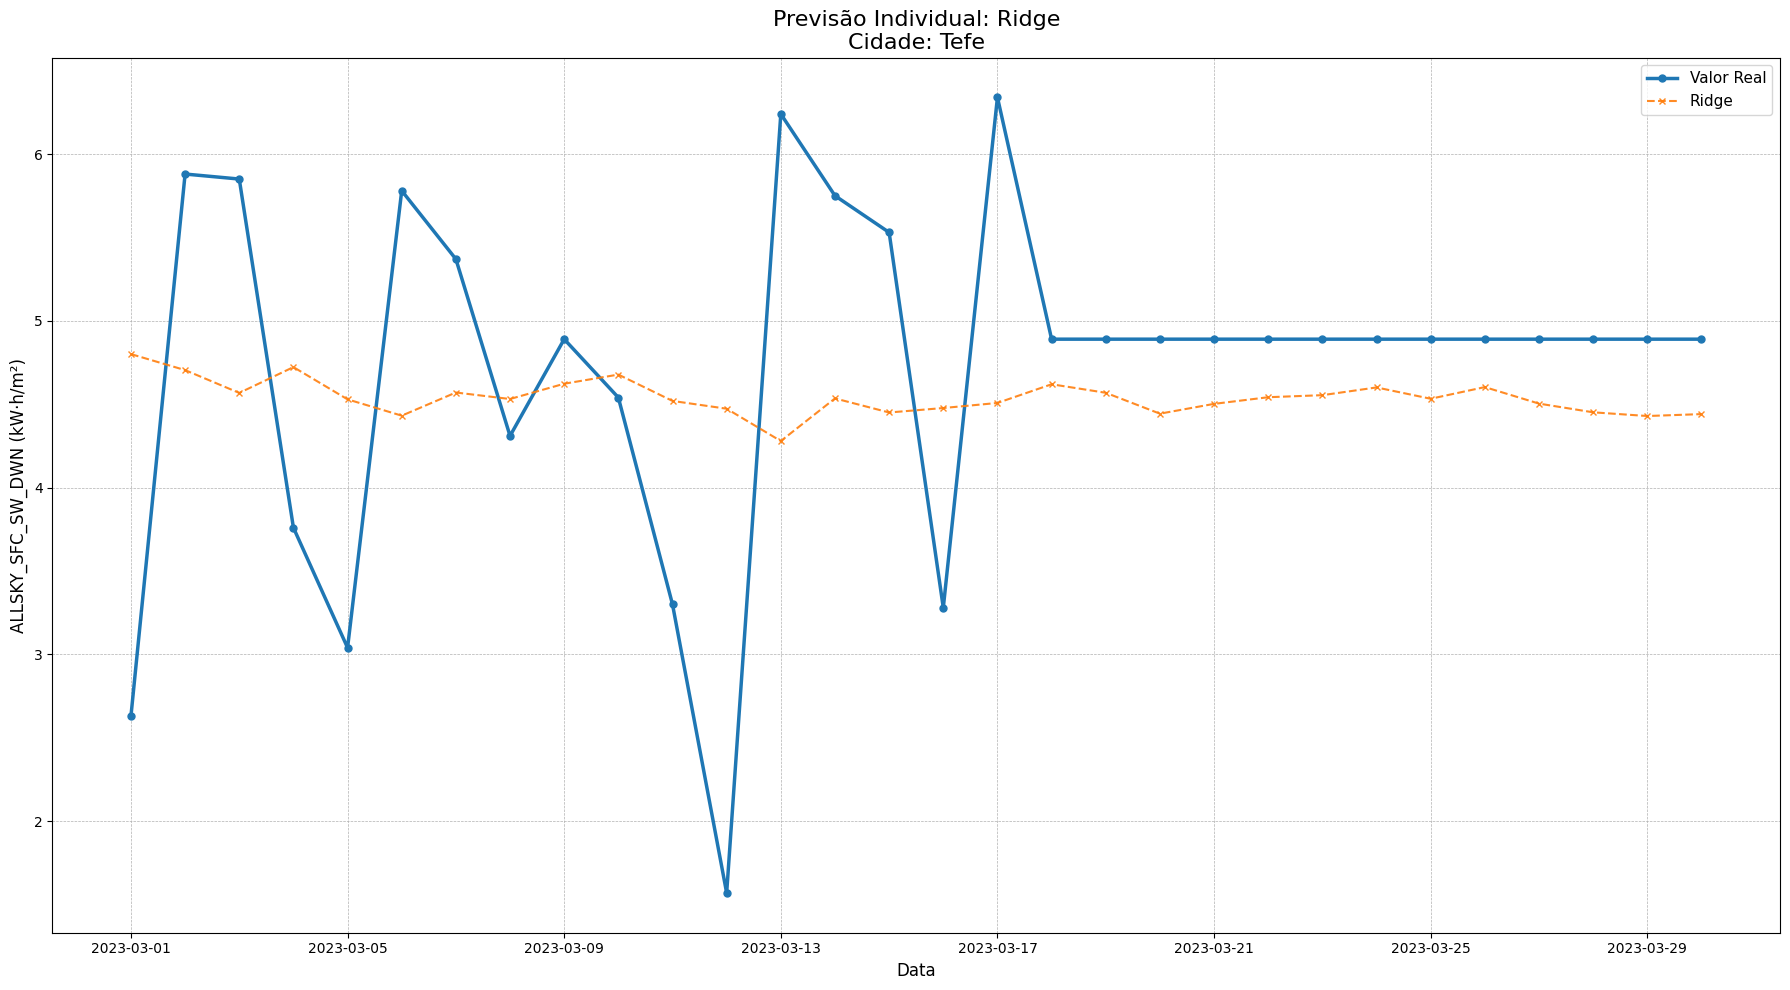

O modelo Ridge não possui o atributo 'feature_importances_'.

Iniciando RandomizedSearchCV para: SVR
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Resultados para SVR: MAE = 0.7608, R2 = -0.0397
Melhores parâmetros: {'model__C': np.float64(2.406242504141576), 'model__epsilon': np.float64(0.2723873301291946), 'model__gamma': np.float64(0.04008609717152555), 'model__kernel': 'rbf'}
Gerando gráfico individual para: SVR


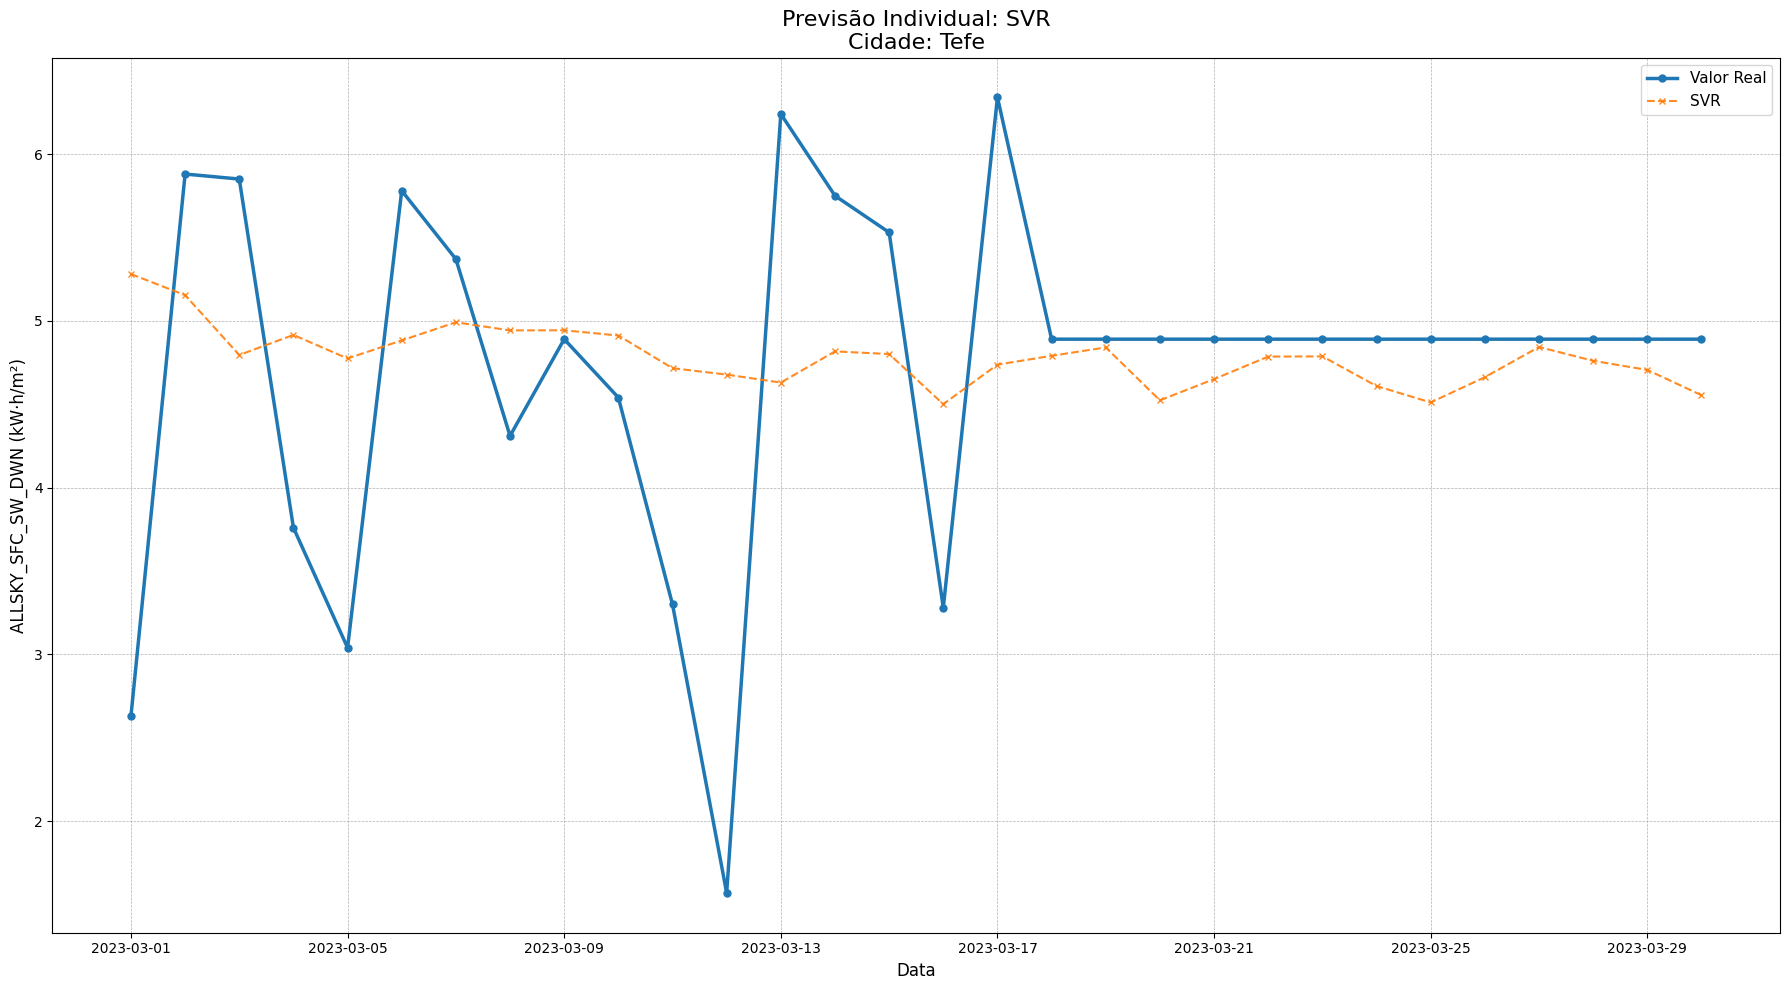

O modelo SVR não possui o atributo 'feature_importances_'.

Iniciando RandomizedSearchCV para: Random Forest
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Resultados para Random Forest: MAE = 0.8021, R2 = -0.0145
Melhores parâmetros: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 201}
Gerando gráfico individual para: Random Forest


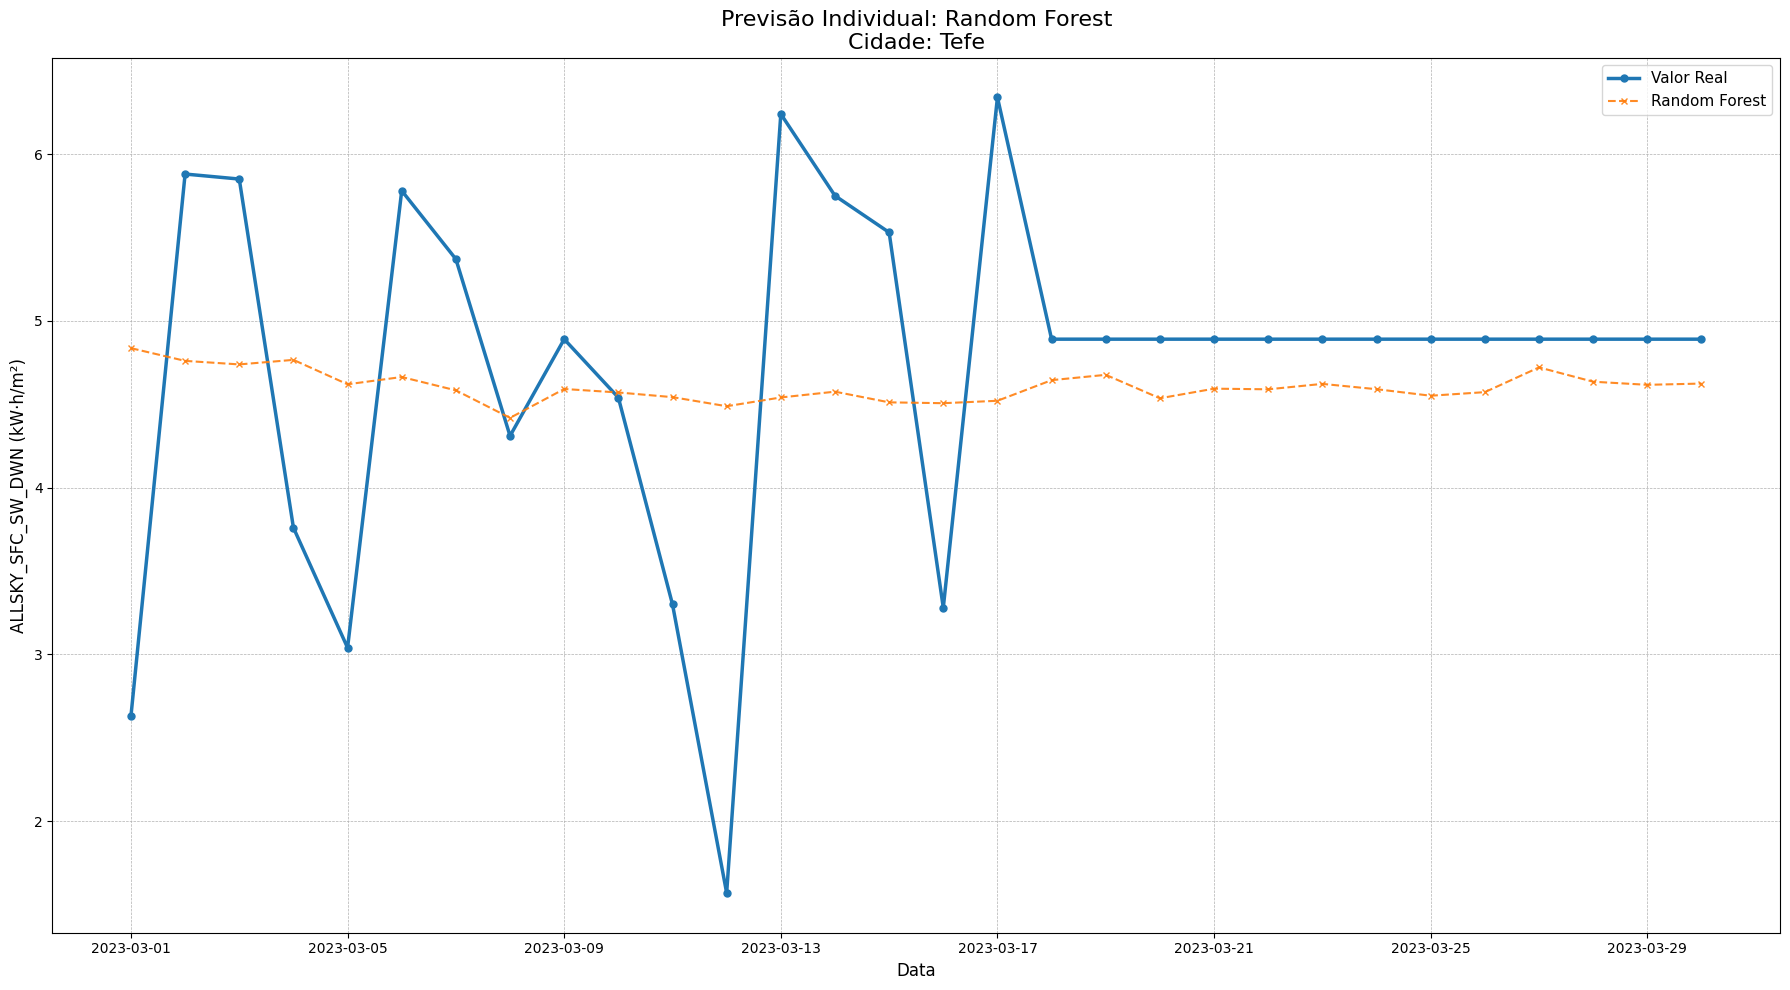

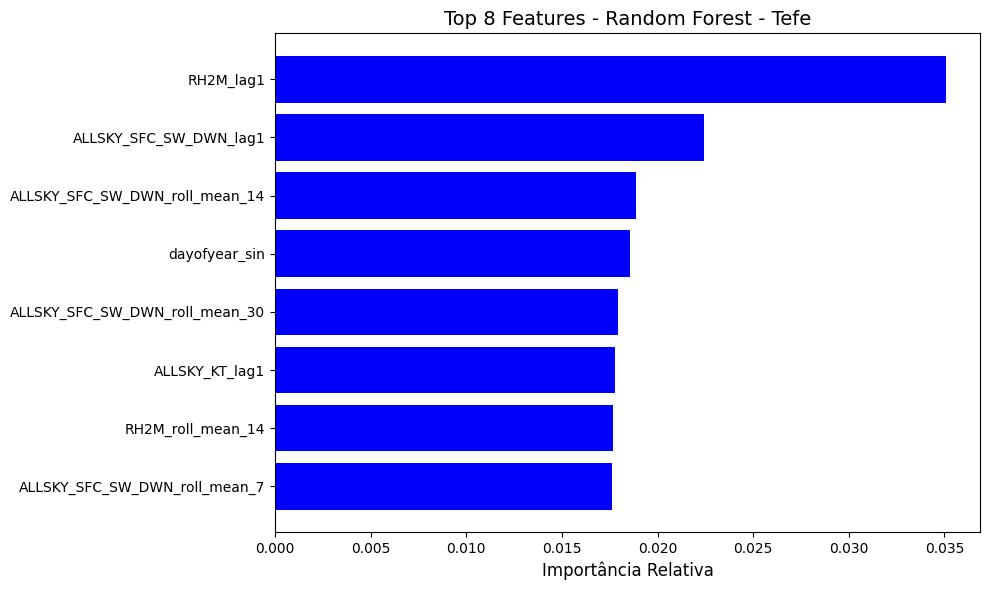


Iniciando RandomizedSearchCV para: XGBoost
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Resultados para XGBoost: MAE = 0.8552, R2 = -0.0651
Melhores parâmetros: {'colsample_bytree': np.float64(0.8233173814428391), 'gamma': np.float64(0.44131817159466985), 'learning_rate': np.float64(0.03830606625120691), 'max_depth': 11, 'n_estimators': 298, 'reg_alpha': np.float64(0.7003578299727713), 'reg_lambda': np.float64(0.8466611422383059), 'subsample': np.float64(0.942529716751237)}
Gerando gráfico individual para: XGBoost


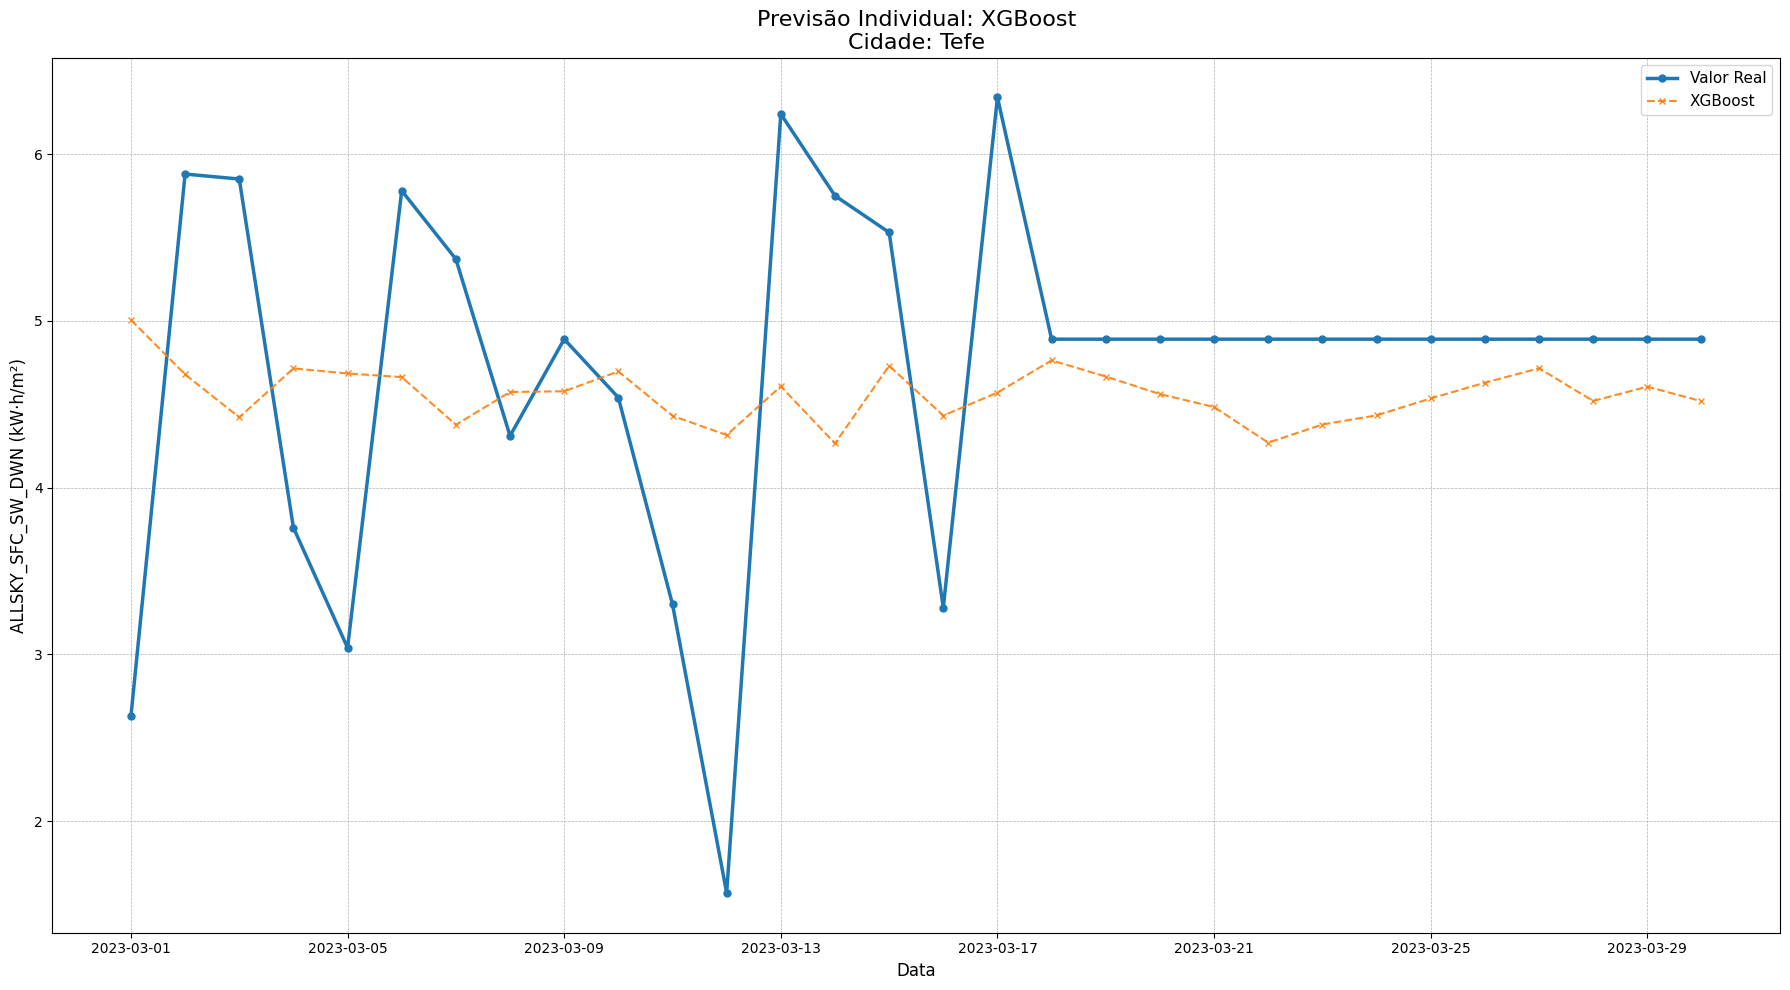

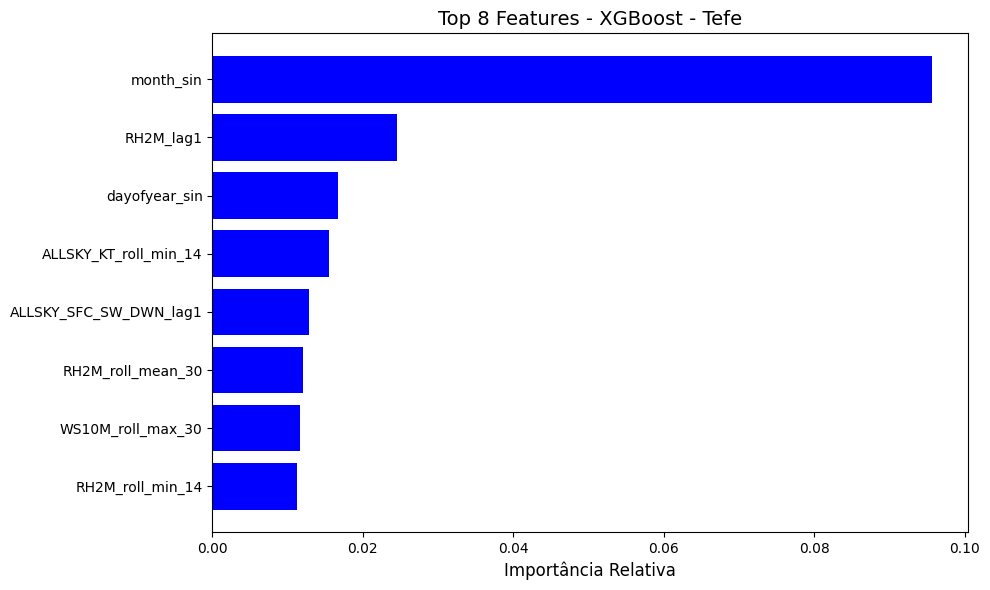


--- Treinamento Sklearn Concluído ---


In [165]:
print("--- Iniciando Otimização e Treinamento dos Modelos Sklearn ---")

for name, estimator, param_dist in MODELS_TO_RUN:
    print(f"\nIniciando RandomizedSearchCV para: {name}")
    start = time.time()
    
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=N_ITER_RANDOM_SEARCH,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    
    search.fit(X_train, y_train.values.ravel())
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred = np.maximum(y_pred, 0) # Garantir não-negatividade
    end = time.time()
    
    # Armazenar resultados
    all_metrics[name] = calculate_metrics(y_test, y_pred, y_train, name, STATION, end - start)
    preds[name] = y_pred
    trained_models[name] = best_model
    
    print(f"Resultados para {name}: MAE = {all_metrics[name]['MAE']:.4f}, R2 = {all_metrics[name]['R2']:.4f}")
    print(f"Melhores parâmetros: {search.best_params_}")
    
    print(f"Gerando gráfico individual para: {name}")
    plot_comparison(
        test_index=y_test.index,
        y_true=y_test.values,
        preds_dict={name: y_pred},
        title=f"Previsão Individual: {name}",
        station_name=STATION,
        target_var=TARGET_VARIABLE,
        save=SAVE_PLOTS,
        folder=PLOTS_FOLDER
    )

    # Plotar importância das features (se aplicável)
    plot_feature_importance(
        model=trained_models[name],
        feature_names=X_train.columns,
        model_name=name,
        station_name=STATION,
        save=SAVE_PLOTS,
        folder=PLOTS_FOLDER
    )
    
print("\n--- Treinamento Sklearn Concluído ---")

### 8. Resultados e Comparações

In [166]:
results_df = pd.DataFrame.from_dict(all_metrics, orient='index').sort_values(by='MAE').reset_index(drop=True)
save_result(results_df, STATION, RESULTS_FOLDER, save=SAVE_RESULTS)

print("\n=== Replicação — Resultados ===")
display(results_df)


=== Replicação — Resultados ===


,Model,Station,R2,MSE,MAE,MAPE,RMSE,sMAPE(%),MASE,Time(s)
0,SVR,Tefe,-0.0397,1.1627,0.7608,22.5378,1.0783,17.5954,0.6846,13.36
1,Random Forest,Tefe,-0.0145,1.1346,0.8021,22.4400,1.0652,18.5353,0.7218,148.05
2,XGBoost,Tefe,-0.0651,1.1911,0.8552,23.2983,1.0914,19.7205,0.7696,37.93
3,Ridge,Tefe,-0.0874,1.2160,0.8680,23.5983,1.1027,19.9847,0.7811,0.54


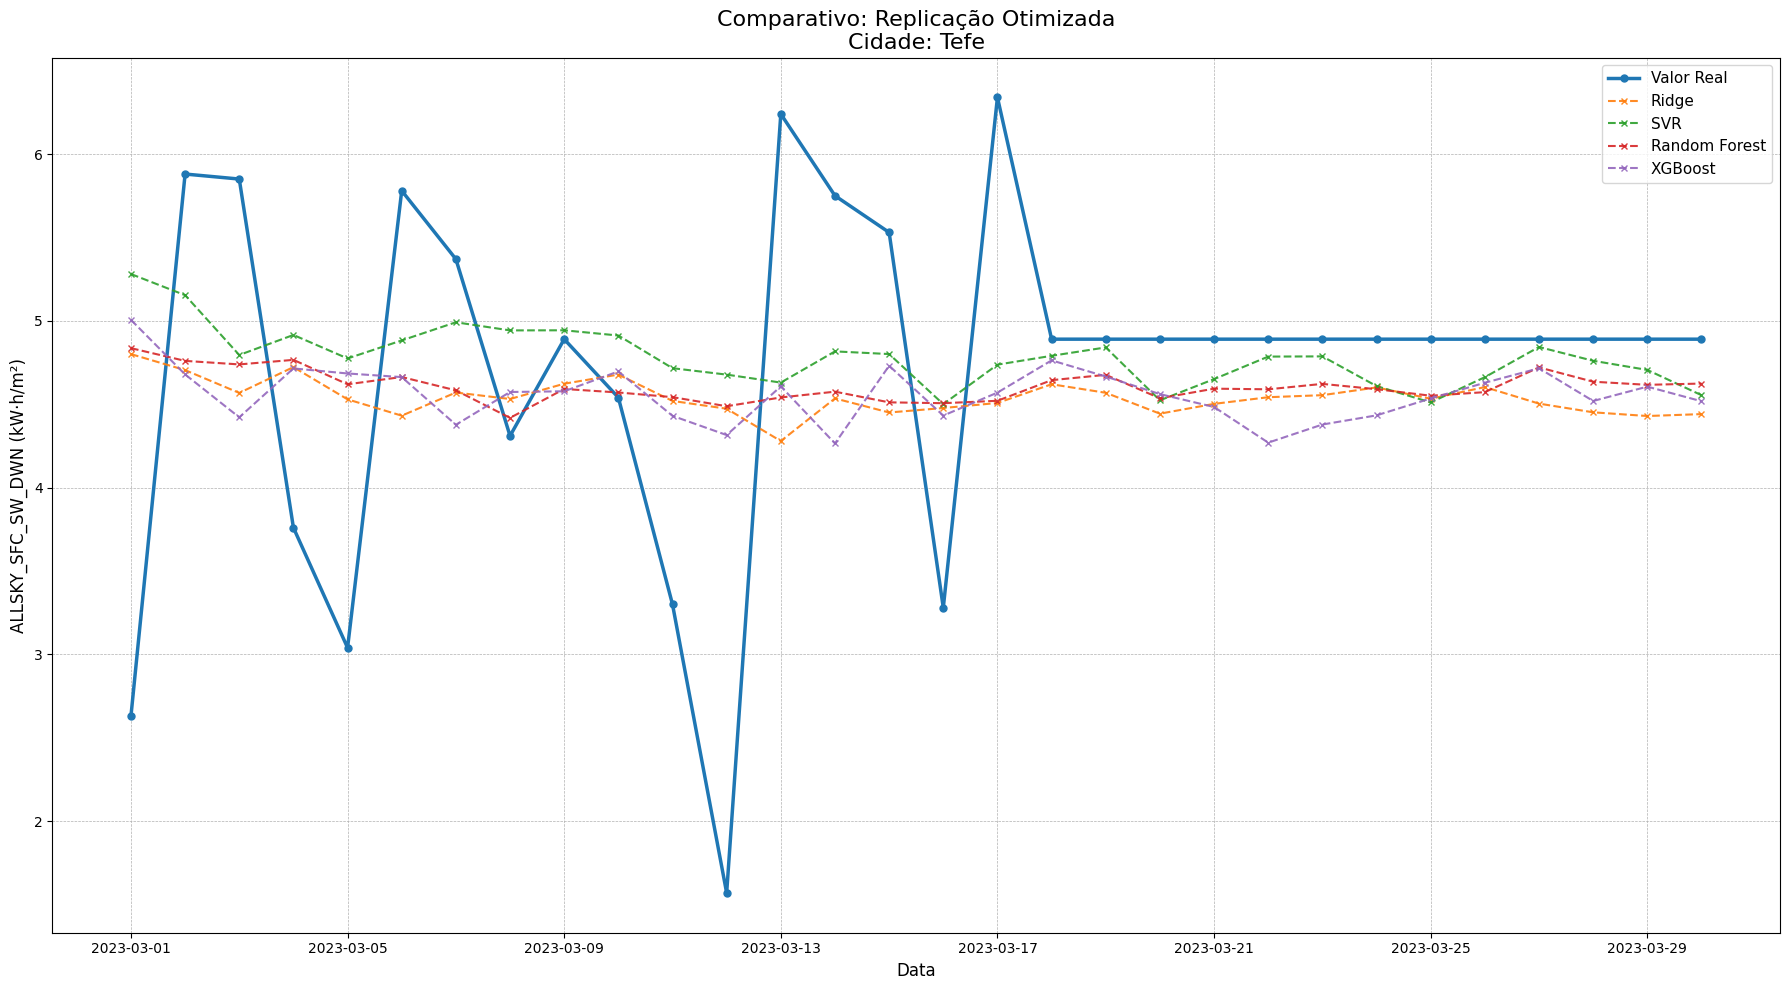

In [167]:
plot_comparison(
    test_index=test_index, 
    y_true=y_test.values, 
    preds_dict=preds,
    title="Comparativo: Replicação Otimizada",
    station_name=STATION,
    target_var=TARGET_VARIABLE,
    save=SAVE_PLOTS,
    folder=PLOTS_FOLDER
)

### 9. Backtesting (Origem Rolante)

In [168]:
if DO_BACKTEST:
    print("\n== Iniciando Backtesting (Origem Rolante) ==")

    # Espaços de busca para o backtest
    PARAMS_RIDGE_BT = {'alpha': sp_uniform(0.01, 100)}
    PARAMS_SVR_BT   = {'kernel': ['linear','rbf'],
                       'C': sp_uniform(0.1, 100),
                       'gamma': sp_uniform(1e-4, 1e-1),
                       'epsilon': sp_uniform(0.01, 0.5)}
    PARAMS_RF_BT    = {'n_estimators': sp_randint(200, 800),
                       'max_depth': [None, 10, 20, 30],
                       'min_samples_split': sp_randint(2, 20),
                       'min_samples_leaf': sp_randint(1, 10),
                       'max_features': ['sqrt', 'log2', None]}
    PARAMS_XGB_BT   = {'n_estimators': sp_randint(200, 800),
                       'learning_rate': sp_uniform(0.01, 0.15),
                       'max_depth': sp_randint(3, 10),
                       'subsample': sp_uniform(0.6, 0.4),
                       'colsample_bytree': sp_uniform(0.6, 0.4)}

    # Executar Backtests
    ridge_bt = rolling_backtest_sklearn(Ridge(random_state=RANDOM_STATE), PARAMS_RIDGE_BT,
                                          X_full, y_full, n_splits=N_CV_SPLITS, gap=max_lag_or_window,
                                          n_iter=20, name='Ridge', needs_scaler=True)
    svr_bt   = rolling_backtest_sklearn(SVR(), PARAMS_SVR_BT,
                                          X_full, y_full, n_splits=N_CV_SPLITS, gap=max_lag_or_window,
                                          n_iter=20, name='SVR', needs_scaler=True)
    rf_bt    = rolling_backtest_sklearn(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1), PARAMS_RF_BT,
                                          X_full, y_full, n_splits=N_CV_SPLITS, gap=max_lag_or_window,
                                          n_iter=20, name='Random Forest', needs_scaler=False)
    xgb_bt   = rolling_backtest_sklearn(xgb.XGBRegressor(objective='reg:squarederror',
                                                           tree_method='hist', importance_type='gain',
                                                           random_state=RANDOM_STATE, n_jobs=1),
                                          PARAMS_XGB_BT,
                                          X_full, y_full, n_splits=N_CV_SPLITS, gap=max_lag_or_window,
                                          n_iter=20, name='XGBoost', needs_scaler=False)

    # Consolidar e Exibir Resultados
    all_bt_results = pd.concat([ridge_bt, svr_bt, rf_bt, xgb_bt])
    all_bt_results['Model'] = all_bt_results['Model'].apply(lambda x: x.split(' (')[0])
    all_bt_results['Station'] = STATION
    
    save_result(all_bt_results, STATION, RESULTS_FOLDER, SAVE_RESULTS, 'backtesting_full')

    mean_bt_results = all_bt_results.groupby('Model', as_index=False).mean(numeric_only=True)
    mean_bt_results['Station'] = STATION
    mean_bt_results = mean_bt_results[['Model', 'Station'] + [c for c in mean_bt_results.columns if c not in ['Station', 'Model']]]
    mean_bt_results = mean_bt_results.sort_values(by='MAE')

    print("\n--- Resultados Médios do Backtesting ---")
    save_result(mean_bt_results, STATION, RESULTS_FOLDER, SAVE_RESULTS, 'backtesting_mean')
    display(mean_bt_results)    
else:
    print("\nBacktesting pulado (DO_BACKTEST=False).")


== Iniciando Backtesting (Origem Rolante) ==
Backtest: Ridge - Fold 1/5
Backtest: Ridge - Fold 2/5
Backtest: Ridge - Fold 3/5
Backtest: Ridge - Fold 4/5
Backtest: Ridge - Fold 5/5
Backtest: SVR - Fold 1/5
Backtest: SVR - Fold 2/5
Backtest: SVR - Fold 3/5
Backtest: SVR - Fold 4/5
Backtest: SVR - Fold 5/5
Backtest: Random Forest - Fold 1/5
Backtest: Random Forest - Fold 2/5
Backtest: Random Forest - Fold 3/5
Backtest: Random Forest - Fold 4/5
Backtest: Random Forest - Fold 5/5
Backtest: XGBoost - Fold 1/5
Backtest: XGBoost - Fold 2/5
Backtest: XGBoost - Fold 3/5
Backtest: XGBoost - Fold 4/5
Backtest: XGBoost - Fold 5/5

--- Resultados Médios do Backtesting ---


,Model,Station,R2,MSE,MAE,MAPE,RMSE,sMAPE(%),MASE,Time(s)
0,Random Forest,Tefe,0.05766,1.18688,0.86026,23.86394,1.08634,19.49220,0.80274,56.204
1,Ridge,Tefe,0.02436,1.23084,0.86596,24.30266,1.10500,19.56578,0.80804,0.172
2,SVR,Tefe,-0.04032,1.31254,0.86712,25.28406,1.14090,19.51582,0.80902,2.376
3,XGBoost,Tefe,-0.01922,1.27830,0.89334,24.47652,1.12756,20.21162,0.83318,25.586
